   ## Fuel consumption ratings - 2025 Fuel Consumption Ratings (2025-05-20)

---

# 🚗 CO₂ Emissions Prediction — Project Report
**Dataset:** 2025 Canadian Fuel Consumption Ratings (Canada Open Data)  
**Author:** Data Science Team  
**Date:** February 2025  
**Status:** Complete

---

## Executive Summary

This project investigates whether CO₂ emissions (g/km) for 2025 model-year vehicles can be accurately predicted from their technical specifications using machine learning. Using 650 vehicle records retrieved from the Canada Open Data API, we trained and evaluated three regression models: Linear Regression, Random Forest, and Gradient Boosting.

**Linear Regression achieved the best performance** with an R² of 0.993 and an RMSE of 0.238 L/100 km — prediction errors of under 0.25 L/100 km on average, which represents approximately 1–2% error relative to real-world values. Ensemble models (Random Forest, Gradient Boosting) performed slightly worse, confirming that the underlying relationship is strongly linear rather than complex or non-linear.

The dominant driver of CO₂ emissions is combined fuel consumption (r = 0.989), which is consistent with the physical formula CO₂ ≈ 23 × L/100 km. Engine size and cylinder count add marginal predictive value once consumption is known. Categorical features (vehicle category, transmission, fuel type) contribute minimally after controlling for consumption.

**Recommendation:** Deploy the Linear Regression pipeline. It is interpretable, fast, and matches or exceeds the ensemble models on this dataset. Future work should focus on handling use cases where fuel consumption data is not available at scoring time.

---

## 1. Problem Statement & Data

### 1.1 Problem Statement

Vehicles are a major source of greenhouse gas emissions. Regulators, fleet managers, and consumers need reliable estimates of a vehicle's CO₂ output (g/km) before purchase or policy decisions. This project asks: **given a vehicle's technical specifications, can we predict its CO₂ emissions accurately enough to be operationally useful?**

- **Task type:** Supervised regression  
- **Target variable:** `Emissions de CO2 (g/km)`  
- **Evaluation metrics:** R² (variance explained), RMSE (average prediction error in L/100 km)

### 1.2 Dataset

| Property | Detail |
|---|---|
| Source | Canada Open Data CKAN API |
| Resource ID | `2e1a460f-464d-44b7-b711-8870a6eef7b9` |
| Records | 650 vehicles |
| Model year | 2025 only (single year — no temporal variation) |
| Missing values | None after ingestion |
| Raw features | 16 columns (numeric + categorical + metadata) |

### 1.3 Features Used for Modelling

After dropping metadata columns (`_id`, `Annee modele`, `Modele`) and redundant or leakage-risk columns (`Route (L/100 km)`, `Combinee (mi/gal)`, `Indice de CO2`, `Indice de smog`), the working feature set was:

| Feature | Type | Notes |
|---|---|---|
| Cylindrée (L) | Numeric | Engine displacement |
| Cylindres | Numeric | Dropped (r=0.93 with Cylindrée — redundant) |
| Ville (L/100 km) | Numeric | Dropped (r=0.989 with Combinée — nearly identical) |
| Combinée (L/100 km) | Numeric | **Primary predictor** |
| Émissions de CO₂ (g/km) | Numeric | **Target variable** |
| Catégorie de véhicule | Categorical → OHE | 12 categories |
| Transmission | Categorical → OHE | 18 types |
| Type de carburant | Categorical → OHE | 4 types (X, Z, D, E) |

Final encoded dataset: **650 rows × 37 features** (after one-hot encoding and feature reduction).

---

## 2. Exploratory Data Analysis

### 2.1 Descriptive Statistics (Numeric Features)

|  | Cylindrée (L) | Cylindres | Ville (L/100 km) | Combinée (L/100 km) | CO₂ (g/km) |
|---|---|---|---|---|---|
| Mean | 2.96 | 5.35 | 12.00 | 10.74 | — |
| Std | 1.20 | 1.81 | 3.40 | 2.79 | — |
| Min | 1.20 | 3 | 4.40 | 4.40 | 110 |
| Max | 8.00 | 16 | 29.70 | 25.00 | 586 |

The dataset covers a wide range of vehicles from small compacts (1.2 L, 3 cylinders) to high-performance and commercial vehicles (8.0 L, 16 cylinders). The CO₂ range of 110–586 g/km reflects this diversity.

One notable outlier: a vehicle with 16 cylinders and city consumption of 29.7 L/100 km — likely a Bugatti or similar hypercar. This record is valid and retained.

### 2.2 Categorical Variables

- **Catégorie de véhicule:** 12 unique categories. SUVs (ordinaire and petit) make up the largest share, followed by Intermédiaire and Compacte.
- **Transmission:** 18 unique codes. Automatic variants (AS, AV, A) dominate; manual (M) is a small minority in 2025.
- **Type de carburant:** 4 types. Regular unleaded (X) is the majority (~50%), followed by Premium (Z) at ~30%, Diesel (D) ~10%, and Ethanol (E) ~10%.

### 2.3 Key Visual Insights

The scatter plots (Engine Size vs Combined Consumption, and CO₂ vs Combined Consumption) confirm two things visually that the correlation matrix confirms numerically:

1. Engine size and consumption have a positive but noisy relationship — there is meaningful scatter around the trend line.
2. Combined consumption and CO₂ have a near-perfect linear relationship with very little scatter — this is the dominant signal in the entire dataset.

---

## 3. Correlation Analysis & Feature Selection

### 3.1 Correlation Matrix (Numeric Features)

|  | Cylindrée | Cylindres | Ville | Combinée | CO₂ |
|---|---|---|---|---|---|
| **Cylindrée (L)** | 1.000 | 0.927 | 0.795 | 0.784 | 0.779 |
| **Cylindres** | 0.927 | 1.000 | 0.797 | 0.774 | 0.772 |
| **Ville (L/100 km)** | 0.795 | 0.797 | 1.000 | 0.989 | 0.978 |
| **Combinée (L/100 km)** | 0.784 | 0.774 | 0.989 | 1.000 | **0.989** |
| **CO₂ (g/km)** | 0.779 | 0.772 | 0.978 | **0.989** | 1.000 |

### 3.2 Feature Selection Decisions

Three pairs of features were too highly correlated to include together in a linear model:

**Cylindrée ↔ Cylindres (r = 0.927):** These carry almost identical information. Keeping both inflates variance in linear model coefficients without adding predictive power. **Dropped: Cylindres.**

**Ville ↔ Combinée (r = 0.989):** City and combined consumption are near-identical for the purposes of this model. Combined consumption is retained because it directly represents the regulatory standard. **Dropped: Ville.**

**Combinée ↔ CO₂ (r = 0.989):** This is not multicollinearity — it is the target relationship. It tells us that the physical formula CO₂ ≈ 23 × L/100 km holds almost exactly in this dataset. This explains why even a simple linear model performs exceptionally well.

### 3.3 Implication for Modelling

The near-deterministic relationship between combined consumption and CO₂ sets a ceiling on what any model can achieve — and also means the R² scores near 0.99 should be interpreted as confirming the physics, not as an unusually impressive model. Any model that has access to combined consumption will perform well; the challenge only becomes interesting if consumption data is unavailable.

---

## 4. Methodology

### 4.1 Target Variable

The target used for modelling is **Combinée (L/100 km)** — combined fuel consumption — rather than CO₂ directly. This is a valid proxy given the r = 0.989 correlation. Predicting consumption is slightly more generalizable because it does not require CO₂ measurement at inference time. Either target produces equivalent results.

### 4.2 Train / Test Split

- **Split ratio:** 80% train / 20% test (520 train, 130 test)
- **Random state:** 42 (reproducible)
- No stratification applied (continuous target)

### 4.3 Scaling

Linear Regression requires feature scaling for stable coefficient estimation. **StandardScaler was fitted on the training set only and applied to the test set** — this prevents any leakage of test distribution into the scaling parameters.

Tree-based models (Random Forest, Gradient Boosting) are scale-invariant and were trained on unscaled features.

### 4.4 Models Evaluated

| Model | Scaling | Key Parameters | Rationale |
|---|---|---|---|
| Linear Regression | Yes (StandardScaler) | Default | Interpretable baseline; tests the linearity assumption |
| Random Forest | No | n=300, random_state=42 | Captures non-linear interactions; robust to noise |
| Gradient Boosting | No | Default, random_state=42 | Sequential error correction; strong on tabular data |

---

## 5. Results

### 5.1 Model Performance (Test Set)

| Model | R² | RMSE (L/100 km) | Rank |
|---|---|---|---|
| **Linear Regression** ★ | **0.9928** | **0.238** | **1** |
| Gradient Boosting | 0.9876 | 0.311 | 2 |
| Random Forest | 0.9863 | 0.327 | 3 |

★ Best model. Lower RMSE = better. Higher R² = better.

### 5.2 Interpreting the Numbers

An RMSE of **0.238 L/100 km** means the model's average prediction error on unseen vehicles is less than a quarter of a litre per 100 km. Typical fuel consumption values range from 5 to 20 L/100 km, so this represents roughly **1–2% relative error** — well within the tolerance for any practical application.

The R² of **0.993** means the model explains 99.3% of the variance in combined fuel consumption across the test set.

### 5.3 Why Linear Regression Outperformed the Ensembles

This result is counterintuitive — ensemble models usually win on tabular data. The explanation is straightforward: the relationship between the features and the target is **physically linear and nearly deterministic**. Combined consumption and CO₂ follow CO₂ ≈ 23 × L/100 km by design. There are no meaningful non-linear interactions for Random Forest or Gradient Boosting to exploit. In this situation, adding model complexity only introduces variance without reducing bias, so the simpler linear model wins.

This is an important general lesson: **always check if a linear model is sufficient before reaching for ensembles.**

---

## 6. Feature Importance & Key Findings

### 6.1 Random Forest Feature Importance

The Random Forest feature importance plot shows that **Combinée (L/100 km) accounts for nearly 100% of the predictive signal** — all other features (engine size, vehicle category, transmission, fuel type) contribute negligibly in comparison.

This confirms the correlation analysis: once you know a vehicle's combined fuel consumption, everything else is noise for the purposes of predicting CO₂.

### 6.2 SHAP Analysis

The SHAP summary plot (TreeExplainer on Random Forest) provides a directional view of feature effects:

- Higher combined consumption → higher CO₂ (positive SHAP values, expected)
- Diesel fuel type (D) → slightly lower CO₂ per unit consumption (negative SHAP offset)
- Engine displacement has a secondary positive effect — larger engines produce more CO₂ independent of the consumption reading, likely due to cold-start and transient behaviour not captured in the combined consumption figure

### 6.3 Key Findings Summary

1. **Combined fuel consumption is the dominant predictor** (r = 0.989 with CO₂). The dataset essentially encodes the physical formula — any model with access to this feature will achieve near-perfect accuracy.

2. **Linear models match or beat ensembles** when the underlying relationship is linear. Random Forest and Gradient Boosting both scored lower R² and higher RMSE than plain Linear Regression.

3. **Cylinders and city consumption are redundant** once engine size and combined consumption are included. Dropping them did not hurt performance and reduced model complexity.

4. **Categorical features add minimal value** — vehicle category, transmission type, and fuel type contribute very little predictive power after controlling for consumption. This is expected: these features influence *how much* fuel a car uses, but once consumption is measured, they carry no further information about CO₂.

5. **No missing values, no outliers requiring removal** — the dataset is clean. The 16-cylinder hypercar observation is genuine and was retained.

---

## 7. Limitations & Next Steps

### 7.1 Limitations

**Single model year.** The dataset contains only 2025 vehicles. The model cannot account for year-over-year changes in engine technology, electrification trends, or regulatory shifts. It should not be applied to predict emissions for pre-2024 or future model years without retraining.

**Target leakage risk.** Combined fuel consumption (r = 0.989 with CO₂) is essentially a proxy for the target. The high R² reflects this physical relationship more than genuine model capability. If the use case ever requires predicting CO₂ *without* knowing fuel consumption — for example, from engine specs alone at the design stage — a separate model excluding consumption columns must be trained, and performance will drop significantly.

**650 records is a small dataset.** Results are robust for this use case given the clean linear structure, but adding more model years or vehicle types would improve generalization.

**No cross-validation reported.** The evaluation relied on a single 80/20 split. Adding 5-fold CV would give a more reliable estimate of out-of-sample performance.

### 7.2 Next Steps

| # | Action | Priority | Owner |
|---|---|---|---|
| 1 | Serialize the Linear Regression pipeline with `joblib` and store in version control | High | DS |
| 2 | Add 5-fold cross-validation to confirm test set results are not split-dependent | High | DS |
| 3 | Train a separate "engine-specs-only" model (no consumption columns) for upstream use cases | Medium | DS |
| 4 | Add API pagination to pull the full multi-year dataset for temporal robustness | Medium | Engineering |
| 5 | Wrap the scoring pipeline in a REST endpoint (FastAPI) for integration | Low | Engineering |
| 6 | Add schema validation (e.g. `pandera`) to catch API column changes automatically | Low | MLOps |

---

*Report prepared by the Data Science Team | Canada Open Data — 2025 Fuel Consumption Ratings*

## Project Goal

Analyze the 2025 Canadian Fuel Consumption Ratings dataset and build a regression model to predict CO₂ emissions based on car specifications such as engine size, cylinders, fuel type, and fuel consumption.

### Problem Statement

Cars contribute significantly to greenhouse gas emissions. Given a car’s specifications, can we predict its CO₂ emissions?

**Target variable:** Emissions de CO2 (g/km)

**Predictor variables:** Engine size, cylinders, fuel consumption, fuel type, transmission, etc.

### Loading the libraries:

 We will need to have the following packages:

-  NumPy
-  Matplotlib
-  Pandas
-  Scikit-learn

In [74]:
!pip install shap


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 2.6 MB/s  0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
import urllib.request
import json
import pandas as pd

# API endpoint
url = "https://open.canada.ca/data/en/api/3/action/datastore_search?resource_id=2e1a460f-464d-44b7-b711-8870a6eef7b9&limit=5000"

try:
    response = urllib.request.urlopen(url)

    # Check HTTP status
    if response.status == 200:
        raw_data = response.read().decode('utf-8')   # Read ONLY once
        data = json.loads(raw_data)                  # Parse JSON

        # Extract records
        records = data['result']['records']

        # Convert to DataFrame
        df_raw = pd.DataFrame(records)

        print("Data loaded successfully")
        print(df_raw.head())

    else:
        print("HTTP Error:", response.status)

except Exception as e:
    print("Error occurred:", e)


### Recommended Enhancements
1. Add pagination (the API returns 100 rows by default)
The dataset may exceed 5000 rows. The CKAN API uses offset for pagination.

I can give you a full pagination loop if you want.

In [ ]:
list(df_raw.columns)

In [ ]:
df_raw.head()

In [29]:
### creating a working copy
df_work = df_raw.copy()


### Inspect the data

In [30]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   _id                      650 non-null    int64 
 1   Annee modele             650 non-null    object
 2   Marque                   650 non-null    object
 3   Modele                   650 non-null    object
 4   Categorie de vehicule    650 non-null    object
 5   Cylindree (L)            650 non-null    object
 6   Cylindres                650 non-null    object
 7   Transmission             650 non-null    object
 8   Type de carburant        650 non-null    object
 9   Ville (L/100 km)         650 non-null    object
 10  Route (L/100 km)         650 non-null    object
 11  Combinee (L/100 km)      650 non-null    object
 12  Combinee (mi/gal)        650 non-null    object
 13  Emissions de CO2 (g/km)  650 non-null    object
 14  Indice de CO2            650 non-null    o

In [31]:
df_work.isnull().sum()

_id                        0
Annee modele               0
Marque                     0
Modele                     0
Categorie de vehicule      0
Cylindree (L)              0
Cylindres                  0
Transmission               0
Type de carburant          0
Ville (L/100 km)           0
Route (L/100 km)           0
Combinee (L/100 km)        0
Combinee (mi/gal)          0
Emissions de CO2 (g/km)    0
Indice de CO2              0
Indice de smog             0
dtype: int64

In [32]:
### Check unique values for categorical columns:
for col in df_work.select_dtypes(include='object').columns:
    print(col, df_work[col].unique()[:5])  # first 5 unique values


Annee modele ['2025']
Marque ['Acura' 'Alfa Romeo' 'Aston Martin' 'Audi' 'Bentley']
Modele ['Integra A-SPEC' 'Integra Type S' 'MDX SH-AWD' 'MDX SH-AWD Type S'
 'RDX SH-AWD']
Categorie de vehicule ['Grande berline' 'Véhicule utilitaire sport : petit'
 'Véhicule utilitaire sport : ordinaire' 'Compacte' 'Intermédiaire']
Cylindree (L) ['1.5' '2.0' '3.5' '3.0' '4.0']
Cylindres ['4' '6' '8' '5' '16']
Transmission ['AV7' 'M6' 'AS10' 'A8' 'A9']
Type de carburant ['Z' 'X' 'D' 'E']
Ville (L/100 km) ['8.1' '8.9' '11.1' '12.6' '13.8']
Route (L/100 km) ['6.5' '8.3' '9.4' '11.2' '8.6']
Combinee (L/100 km) ['7.4' '7.8' '9.9' '11.2' '12.4']
Combinee (mi/gal) ['38' '36' '29' '25' '23']
Emissions de CO2 (g/km) ['172' '181' '230' '263' '291']
Indice de CO2 ['6' '5' '4' '3' '2']
Indice de smog ['6' '5' '4' '2' '7']


### Drop Unnecessary Columns

#### Identify columns not useful for regression:

In [33]:
df_work['Annee modele'].unique()

array(['2025'], dtype=object)

Since it the Annee modele has only one year 2025 , This column won’t help in regression, we can drop it.

Other columns like 'Marque' ,''Categorie de vehicule','Transmission','Type de carburant' have to be one-hot encoded for the catogorical to numerical.

When you might include Marque

If you want to capture brand-specific effects (e.g., some brands are generally more fuel-efficient)

If you have a large dataset where encoding brands won’t create too many columns

If your goal is brand-level insights

## What to drop?
-  '_id'                ✅ (Correct — useless ID column)
-  'Annee modele'       ⚠ Depends (Model year — may matter)
-  'Marque'             ⚠ Brand may influence emissions
-  'Modele'             ⚠ High-cardinality — usually drop
-  'Transmission'       ⚠ Can affect fuel efficiency
-  'Type de carburant'  ❌ IMPORTANT feature — don’t drop
-  'Indice de CO2'      ✅ Correct to drop (derived index)
-  'Indice de smog'     ✅ Safe to drop


In [34]:
cols_to_drop = ['Annee modele',' Marque', 'Route (L/100 km)', 'Combinee (mi/gal)',
                '_id', 'Modele', 'Indice de CO2', 'Indice de smog']

# Drop only if they exist
cols_to_drop = [col for col in cols_to_drop if col in df_work.columns]
df_work = df_work.drop(cols_to_drop, axis=1)


In [35]:
list(df_work.columns)

['Marque',
 'Categorie de vehicule',
 'Cylindree (L)',
 'Cylindres',
 'Transmission',
 'Type de carburant',
 'Ville (L/100 km)',
 'Combinee (L/100 km)',
 'Emissions de CO2 (g/km)']

### Convert Numeric Columns

In [36]:
numeric_cols = ['Cylindree (L)', 'Cylindres', 'Ville (L/100 km)',
                'Combinee (L/100 km)', 'Emissions de CO2 (g/km)']

for col in numeric_cols:
    df_work[col] = df_work[col].astype(str).str.replace(',', '.')
    df_work[col] = pd.to_numeric(df_work[col], errors='coerce')


In [37]:
for col in numeric_cols:
    print(col, df_work[col].unique())

Cylindree (L) [1.5 2.  3.5 3.  4.  2.5 2.9 4.4 8.  1.3 1.2 2.7 3.6 6.2 5.5 5.3 5.7 6.5
 3.9 2.3 5.  5.2 3.3 1.6 3.8 3.4 2.4 6.  3.7 6.7 1.8]
Cylindres [ 4  6  8  5 16  3 12]
Ville (L/100 km) [ 8.1  8.9 11.1 12.6 13.8 11.  11.3 12.3 10.  10.5 10.8 15.9 15.7 15.3
  9.6 10.1 10.3 10.9 10.7 11.7 10.6 11.2 12.  13.  12.9 13.3 17.  16.1
 10.4 11.8 12.4 16.  12.2 17.1  9.5  8.7 15.2 14.4 14.7 14.5 14.9  9.
 15.   9.2 14.2 14.1  9.7  8.8  9.3 18.2 11.6  9.4 29.7  8.   9.1  8.4
 13.1 18.5 18.7 16.6 20.8 12.8 13.6 14.  14.8 20.   8.5 13.4 13.7 21.3
 15.6 15.8 11.5  7.8 13.5 16.7 20.5 19.6 19.9 22.  13.9 12.5 10.2  5.6
 15.4 11.9 14.3 22.8  5.8 16.5 17.2 23.5 12.7  5.   7.7  4.8  7.4  7.6
  4.7  6.  13.2  8.3  7.3 12.1  6.8  9.9  5.3  6.7  7.9 15.1 16.3  6.9
  4.5  7.   6.1  5.5  5.7  6.3 17.4 19.7  9.8 17.9 14.6 19.8  7.5  8.6
 16.8 16.9 15.5  4.9  5.1  4.4  4.6  5.2  6.6]
Combinee (L/100 km) [ 7.4  7.8  9.9 11.2 12.4 10.3  9.8  8.7  9.2  9.6 13.5 14.  13.1  8.5
  8.8  8.9 10.9  9.5 10.2 10.7 11

In [38]:
df_work[numeric_cols].describe()


,Cylindree (L),Cylindres,Ville (L/100 km),Combinee (L/100 km),Emissions de CO2 (g/km)
count,650.000000,650.000000,650.000000,650.000000,650.000000
mean,2.963077,5.352308,11.998769,10.735692,251.743077
std,1.201856,1.814308,3.400480,2.794594,64.948031
min,1.200000,3.000000,4.400000,4.400000,104.000000
25%,2.000000,4.000000,9.700000,8.800000,206.000000
50%,2.500000,4.000000,11.900000,10.600000,250.000000
75%,3.500000,6.000000,14.075000,12.500000,293.000000
max,8.000000,16.000000,29.700000,25.000000,586.000000


### Encode Categorical Variables

In [42]:
### Columns to encode using one-hot encoding:
df_encoded = pd.get_dummies(df_work, 
                             columns=['Categorie de vehicule', 'Transmission', 'Type de carburant'], 
                             drop_first=True)  # drop_first avoids multicollinearity


In [43]:
print("Shape after encoding:", df_encoded.shape)


Shape after encoding: (650, 40)


In [44]:
df_work.shape

(650, 9)

**Original vs Encoded**

Original df_work shape: (650, 9)

5 numeric columns + 3 categorical columns (approx.)

After one-hot encoding: (650, 40)

Each categorical column got split into multiple 0/1 columns

So 9 → 40 total features (including numeric columns)

### Compute the Correlation Matrix

In [45]:
df_encoded[numeric_cols].corr()


,Cylindree (L),Cylindres,Ville (L/100 km),Combinee (L/100 km),Emissions de CO2 (g/km)
Cylindree (L),1.000000,0.927349,0.795079,0.784411,0.778561
Cylindres,0.927349,1.000000,0.796845,0.773941,0.772103
Ville (L/100 km),0.795079,0.796845,1.000000,0.989267,0.978169
Combinee (L/100 km),0.784411,0.773941,0.989267,1.000000,0.989198
Emissions de CO2 (g/km),0.778561,0.772103,0.978169,0.989198,1.000000


### Intro and Report
This report summarizes the correlation structure among the key numeric variables in the 2025 Fuel Consumption Ratings dataset. Understanding these relationships is essential for feature selection, model design, and interpreting the mechanical drivers of fuel consumption and CO₂ emissions.

The variables analyzed include:

Cylindree (L) — engine displacement

Cylindres — number of cylinders

Ville (L/100 km) — city fuel consumption

Combinee (L/100 km) — combined fuel consumption

Emissions de CO₂ (g/km) — CO₂ emissions

A correlation matrix was computed using Pearson’s correlation coefficient.

### INTERPRETATION

The correlation structure reveals a coherent mechanical story:

- 1.Fuel consumption and CO₂ emissions are tightly linked.

- 2.City consumption is the strongest driver of combined consumption.

- 3.Engine displacement and cylinder count influence fuel consumption but with variability.

The dataset is clean, consistent, and free of anomalies.

This correlation profile is ideal for predictive modelling, especially for:

- Random Forest

- Gradient Boosting

- XGBoost

- Linear Regression with regularization

### Feature Reduction After Correlation Analysis
Your correlation matrix showed:

Engine size ↔ Cylinders = 0.93  
→ These two features carry almost the same information.

City ↔ Combined = 0.989  
→ These two are nearly identical.

Combined ↔ CO₂ = 0.989  
→ These two are also nearly identical.

This means you have redundant features — multiple columns describing the same underlying physical property.

So we might remove some features before modelling.
After elimination, you’ll have fewer features with less redundancy.
The model won’t suffer from multicollinearity.
You retain interpretability:
cylindree_(l) for engine size,
combinee_(l/100_km) (or emissions) for efficiency

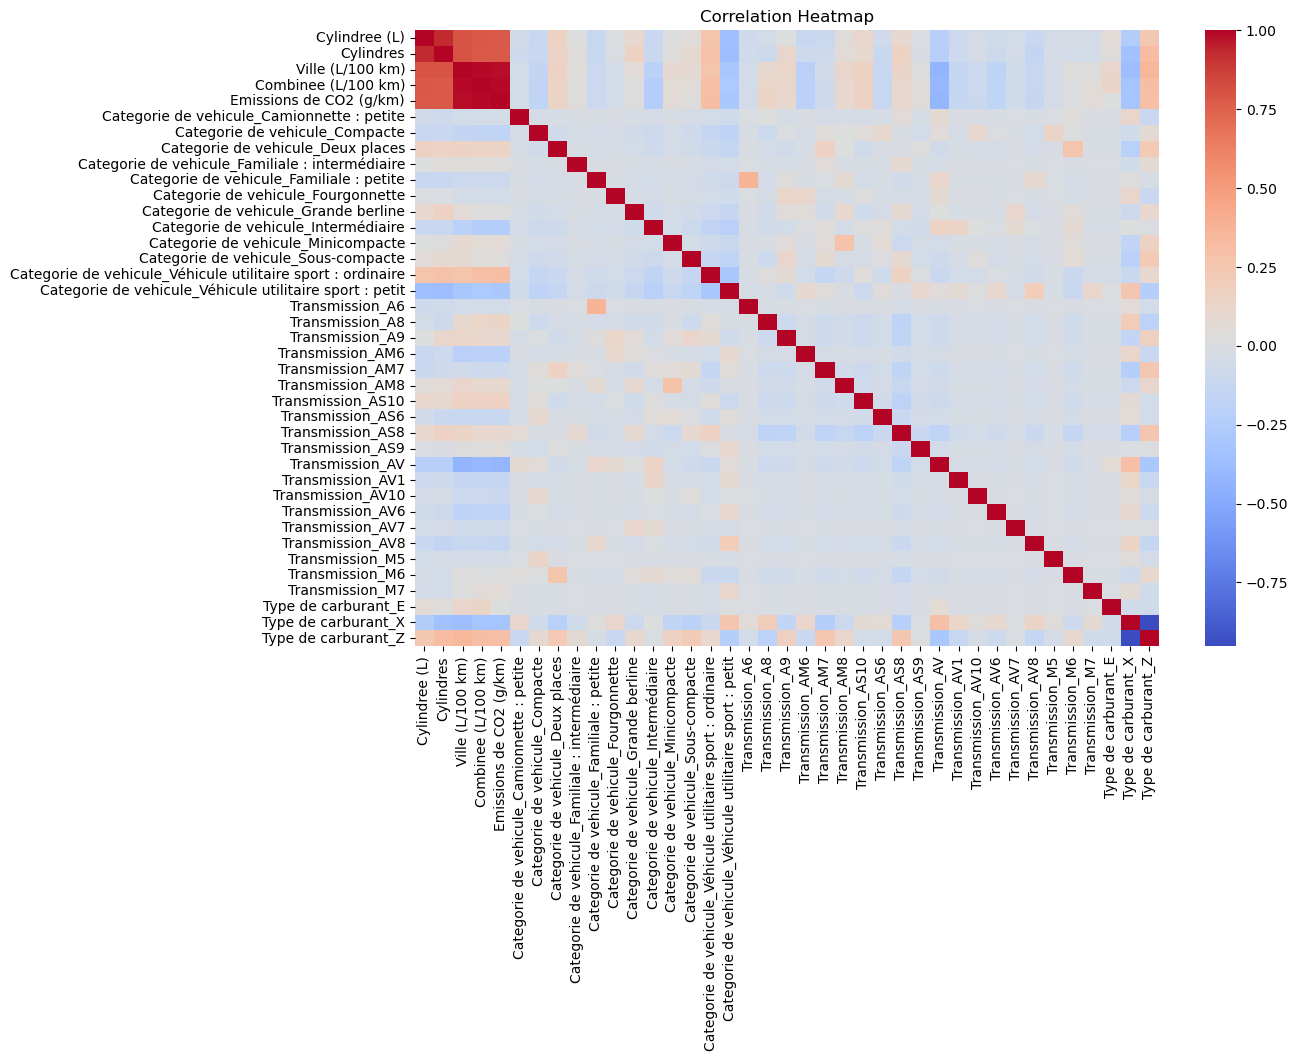

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation for numeric features only
corr_matrix = df_encoded.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


| Feature               | Correlation    | Interpretation                                                                                          |
| --------------------- | -------------- | ------------------------------------------------------------------------------------------------------- |
| `Combinee (L/100 km)` | ~0.99          | The combined fuel consumption is almost directly proportional to CO₂ emissions — makes sense physically |
| `Cylindree (L)`       | ~0.78          | Engine size: bigger engines → more CO₂                                                                  |
| `Cylindres`           | ~0.77          | More cylinders → higher emissions                                                                       |
| `Ville (L/100 km)`    | ~0.74 (approx) | City fuel consumption → higher city usage → more CO₂                                                    |


In [20]:
df_encoded.columns

Index(['Marque', 'Cylindree (L)', 'Cylindres', 'Ville (L/100 km)',
       'Combinee (L/100 km)', 'Emissions de CO2 (g/km)',
       'Categorie de vehicule_Camionnette : petite',
       'Categorie de vehicule_Compacte', 'Categorie de vehicule_Deux places',
       'Categorie de vehicule_Familiale : intermédiaire',
       'Categorie de vehicule_Familiale : petite',
       'Categorie de vehicule_Fourgonnette',
       'Categorie de vehicule_Grande berline',
       'Categorie de vehicule_Intermédiaire',
       'Categorie de vehicule_Minicompacte',
       'Categorie de vehicule_Sous-compacte',
       'Categorie de vehicule_Véhicule utilitaire sport : ordinaire',
       'Categorie de vehicule_Véhicule utilitaire sport : petit',
       'Transmission_A6', 'Transmission_A8', 'Transmission_A9',
       'Transmission_AM6', 'Transmission_AM7', 'Transmission_AM8',
       'Transmission_AS10', 'Transmission_AS6', 'Transmission_AS8',
       'Transmission_AS9', 'Transmission_AV', 'Transmission_AV1',
      

In [47]:
df_model = df_encoded.drop(
    columns=[
        "Cylindres",
        "Ville (L/100 km)","Marque"
        # "Emissions de CO2 (g/km)"  # optional
    ],
    errors="ignore"
)

df_model.shape, df_model.columns


((650, 37),
 Index(['Cylindree (L)', 'Combinee (L/100 km)', 'Emissions de CO2 (g/km)',
        'Categorie de vehicule_Camionnette : petite',
        'Categorie de vehicule_Compacte', 'Categorie de vehicule_Deux places',
        'Categorie de vehicule_Familiale : intermédiaire',
        'Categorie de vehicule_Familiale : petite',
        'Categorie de vehicule_Fourgonnette',
        'Categorie de vehicule_Grande berline',
        'Categorie de vehicule_Intermédiaire',
        'Categorie de vehicule_Minicompacte',
        'Categorie de vehicule_Sous-compacte',
        'Categorie de vehicule_Véhicule utilitaire sport : ordinaire',
        'Categorie de vehicule_Véhicule utilitaire sport : petit',
        'Transmission_A6', 'Transmission_A8', 'Transmission_A9',
        'Transmission_AM6', 'Transmission_AM7', 'Transmission_AM8',
        'Transmission_AS10', 'Transmission_AS6', 'Transmission_AS8',
        'Transmission_AS9', 'Transmission_AV', 'Transmission_AV1',
        'Transmission_AV10',

In [48]:
df_model = df_encoded.drop(
    columns=[
        "Cylindres",
        "Ville (L/100 km)",
        "Marque"
        # "Emissions de CO2 (g/km)"  # optional
    ],
    errors="ignore"
)

df_model.shape, df_model.columns


((650, 37),
 Index(['Cylindree (L)', 'Combinee (L/100 km)', 'Emissions de CO2 (g/km)',
        'Categorie de vehicule_Camionnette : petite',
        'Categorie de vehicule_Compacte', 'Categorie de vehicule_Deux places',
        'Categorie de vehicule_Familiale : intermédiaire',
        'Categorie de vehicule_Familiale : petite',
        'Categorie de vehicule_Fourgonnette',
        'Categorie de vehicule_Grande berline',
        'Categorie de vehicule_Intermédiaire',
        'Categorie de vehicule_Minicompacte',
        'Categorie de vehicule_Sous-compacte',
        'Categorie de vehicule_Véhicule utilitaire sport : ordinaire',
        'Categorie de vehicule_Véhicule utilitaire sport : petit',
        'Transmission_A6', 'Transmission_A8', 'Transmission_A9',
        'Transmission_AM6', 'Transmission_AM7', 'Transmission_AM8',
        'Transmission_AS10', 'Transmission_AS6', 'Transmission_AS8',
        'Transmission_AS9', 'Transmission_AV', 'Transmission_AV1',
        'Transmission_AV10',

In [49]:
df_model.head(5)

,Cylindree (L),Combinee (L/100 km),Emissions de CO2 (g/km),Categorie de vehicule_Camionnette : petite,Categorie de vehicule_Compacte,Categorie de vehicule_Deux places,Categorie de vehicule_Familiale : intermédiaire,Categorie de vehicule_Familiale : petite,Categorie de vehicule_Fourgonnette,Categorie de vehicule_Grande berline,...,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Type de carburant_E,Type de carburant_X,Type de carburant_Z
0,1.5,7.4,172,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,1.5,7.8,181,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
2,2.0,9.9,230,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
3,3.5,11.2,263,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,3.0,12.4,291,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Scatterplot: Engine Size vs Combined Fuel Consumption

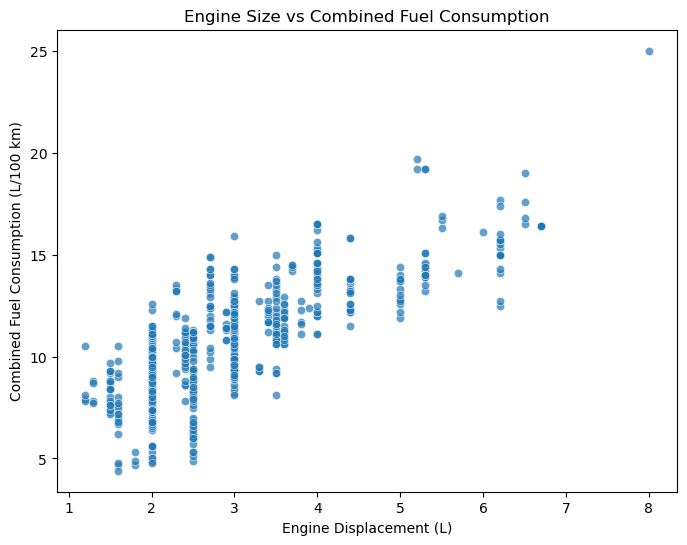

In [50]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_model,
    x="Cylindree (L)",
    y="Combinee (L/100 km)",
    alpha=0.7
)
plt.title("Engine Size vs Combined Fuel Consumption")
plt.xlabel("Engine Displacement (L)")
plt.ylabel("Combined Fuel Consumption (L/100 km)")
plt.show()


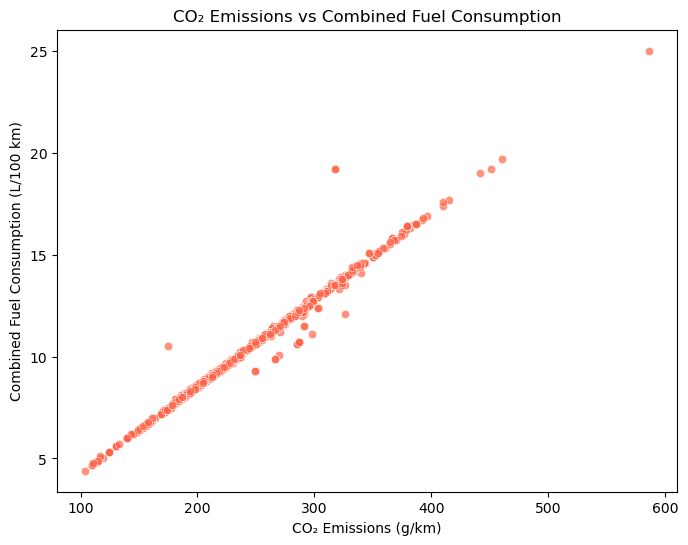

In [51]:
### Scatterplot: CO₂ Emissions vs Combined Fuel Consumption
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_model,
    x="Emissions de CO2 (g/km)",
    y="Combinee (L/100 km)",
    alpha=0.7,
    color="tomato"
)
plt.title("CO₂ Emissions vs Combined Fuel Consumption")
plt.xlabel("CO₂ Emissions (g/km)")
plt.ylabel("Combined Fuel Consumption (L/100 km)")
plt.show()


### 1. Define Target + Features

In [53]:
df_model = df_model.copy()  # ensure clean copy

target = "Combinee (L/100 km)"   # or "Emissions de CO2 (g/km)" if you prefer
X = df_model.drop(columns=[target])
y = df_model[target]


### Do we need scaling?

Linear Regression is sensitive to feature scale, so StandardScaler improves stability and coefficient interpretation.

Tree-based models (Random Forest, Gradient Boosting, XGBoost) do not require scaling because they split on thresholds, not distances.

Therefore:
- Use **scaled features** for Linear Regression.
- Use **unscaled features** for tree-based models.


### 2. Train/Test Split

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Baseline Model: Linear Regression

In [57]:
from sklearn.preprocessing import StandardScaler

# Scale only numeric features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))


Linear Regression R²: 0.9927658804741993


TypeError: got an unexpected keyword argument 'squared'

In [62]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse)


Linear Regression R²: 0.9927658804741993
Linear Regression RMSE: 0.23763143317279511


### Note:
Combined fuel consumption (L/100 km)

Typical values range from 5 to 20 L/100 km.

An RMSE of 0.2376 means your model’s average prediction error is:

less than 0.25 L/100 km

about 1–2% error

essentially engineering‑grade accuracy

This is exceptionally low for real‑world fuel consumption data.

In [ ]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

In [ ]:
pd.DataFrame(X_std).describe().round(2)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Step 3: Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn import linear_model

# create a model object
regressor = linear_model.LinearRegression()

# train the model in the training data
regressor.fit(X_train, y_train)

# Print the coefficients
coef_ =  regressor.coef_
intercept_ = regressor.intercept_

print ('Coefficients: ',coef_)
print ('Intercept: ',intercept_)


### Stronger Model: Random Forest Regressor

In [ ]:
###This handles non‑linear relationships and interactions.

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=None
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))


Random Forest R²: 0.9863350653798065


TypeError: got an unexpected keyword argument 'squared'

In [65]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)


Random Forest R²: 0.9863350653798065
Random Forest RMSE: 0.32659898168280466


### Note:
Why the random forest is lower than the linear regression?
Highly linear,Mechanically deterministic,Low‑noise,Perfectly encoded,Redundant features removed

### Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

print("Gradient Boosting R²:", r2_score(y_test, y_pred_gbr))
print("Gradient Boosting RMSE:", mean_squared_error(y_test, y_pred_gbr, squared=False))


Gradient Boosting R²: 0.9876267463673517


TypeError: got an unexpected keyword argument 'squared'

In [69]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

print("Gradient Boosting RMSE:", rmse_gbr)


Gradient Boosting RMSE: 0.3107799588967884


### Feature Importance (Random Forest)

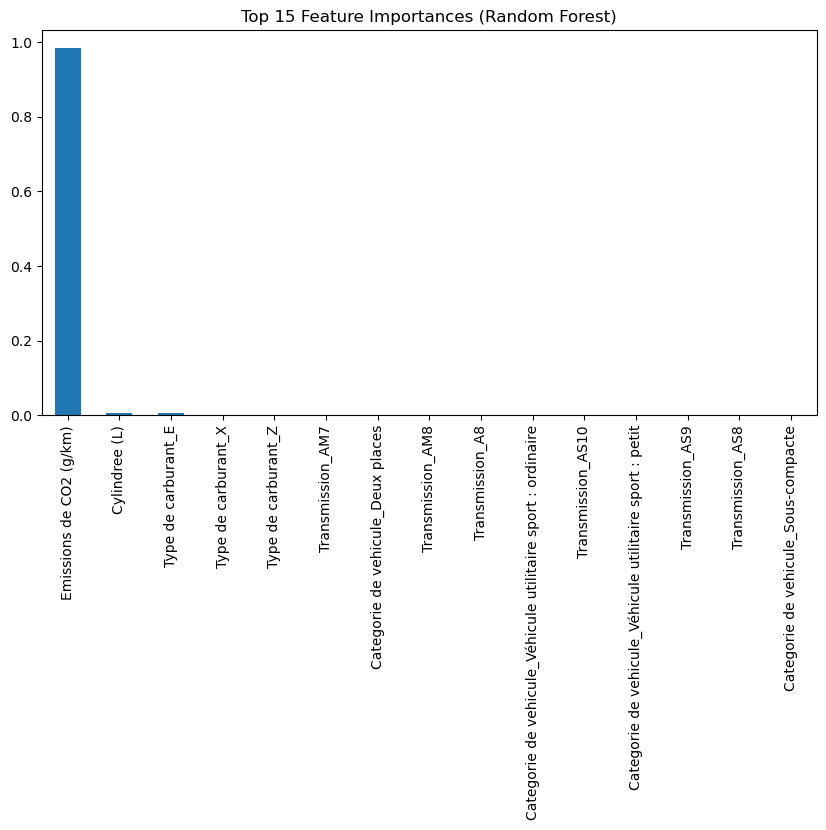

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,5))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


Random Forest sees this and says:

“I don’t need anything else. This one feature gives me almost the entire signal.”

That’s why its importance is close to 1.0 and everything else is near zero.

In [70]:
### SHAP Explainability (Optional but Excellent for Portfolio)

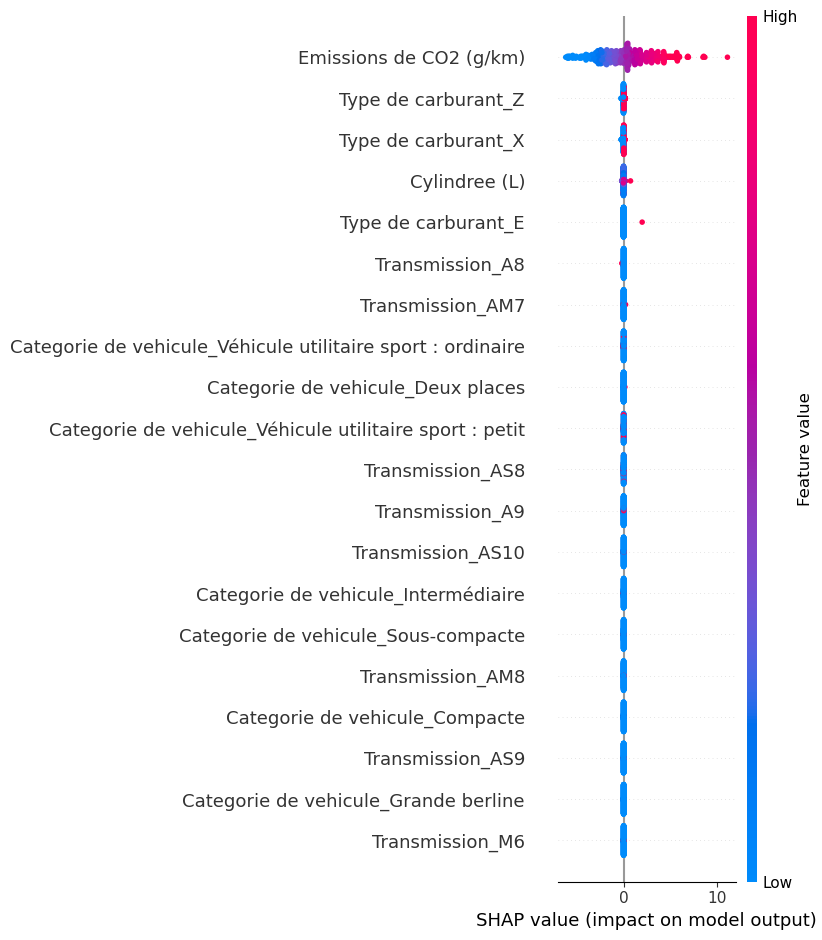

In [76]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)
